### `import` Packages

In [1]:
import os

import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
from tqdm import tqdm

### Data Reading

In [2]:
train_df = pd.read_csv(filepath_or_buffer='data/train.csv')

In [3]:
train_df.shape

(9437519, 2)

In [4]:
train_df.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


### `NaN` Checking

In [5]:
train_df.isnull().sum()

source_node         0
destination_node    0
dtype: int64

### `Duplicate` Checking

In [6]:
train_df.duplicated().sum()

0

### Single Node Analysis

In [7]:
class NodeInfoFetcher:
    def __init__(self, node, df, source_col, dest_col):
        self.node = node
        self.df = df
        self.source_col = source_col
        self.dest_col = dest_col
        
        self.snode_df = self.df[self.df[self.source_col] == self.node]
        self.dnode_df = self.df[self.df[self.dest_col] == self.node]
    
    def fetch_node_info(self):
        node_following = set(self.snode_df[self.dest_col].to_list())
        node_followed = set(self.dnode_df[self.source_col].to_list())

        outdeg_count = len(node_following)
        indeg_count = len(node_followed)

        # print("Node : {}".format(self.node))
        # print('-'*20)
        # print('Following : {}'.format(node_following))
        # print('Count : {}'.format(outdeg_count))
        # print('-'*20)
        # print('Followed : {}'.format(node_followed))
        # print('Count : {}'.format(indeg_count))
        # print('-'*20)
        
        return indeg_count, outdeg_count
    
    def plot_following(self):
        node_following = list(set(self.snode_df[self.dest_col].to_list()))
    
        nfing_list = list(zip([self.node] * len(node_following), node_following))
        nfing_array = np.matrix(list(map(list, nfing_list)))
        nfing_df = pd.DataFrame(data=nfing_array, columns=self.df.columns)
        
        node_graph = nx.from_pandas_edgelist(
            df=nfing_df,
            source=self.source_col,
            target=self.dest_col,
            create_using=nx.DiGraph()
        )
        print(nx.info(G=node_graph))
        self._plot_graph(Graph=node_graph)
        
        return None
    
    def plot_followed(self):
        node_followed = list(set(self.dnode_df[self.source_col].to_list()))
    
        nfwed_list = list(zip([self.node] * len(node_followed), node_followed))
        nfwed_array = np.matrix(list(map(list, nfwed_list)))
        nfwed_df = pd.DataFrame(data=nfwed_array, columns=self.df.columns)

        node_graph = nx.from_pandas_edgelist(
            df=nfwed_df,
            source=self.dest_col,
            target=self.source_col,
            create_using=nx.DiGraph()
        )
        print(nx.info(G=node_graph))
        self._plot_graph(Graph=node_graph)
        
        return None
    
    def _plot_graph(self, Graph):
        pos = nx.spring_layout(Graph)
        
        nx.draw(
            G=Graph,
            pos=pos,
            node_color='#A0CBE2',
            edge_color='#00bb5e',
            width=1,
            edge_cmap=plt.cm.Blues,
            with_labels=True
        )
        plt.show()
        
        return None

### Fetch Node Information

In [8]:
nif = NodeInfoFetcher(
    node=1,
    df=train_df,
    source_col='source_node',
    dest_col='destination_node'
)

In [9]:
nif.fetch_node_info()

(3, 3)

Name: 
Type: DiGraph
Number of nodes: 4
Number of edges: 3
Average in degree:   0.7500
Average out degree:   0.7500


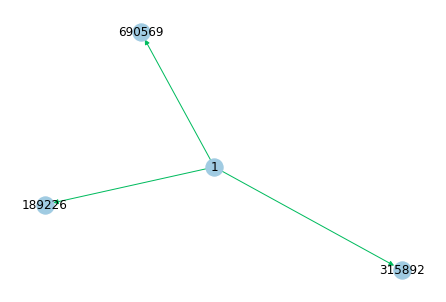

In [10]:
nif.plot_following()

Name: 
Type: DiGraph
Number of nodes: 4
Number of edges: 3
Average in degree:   0.7500
Average out degree:   0.7500


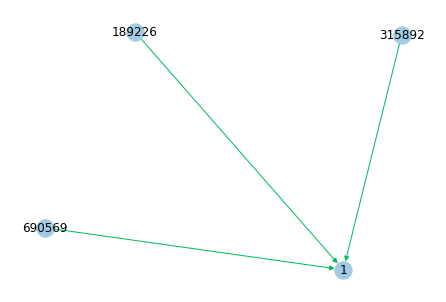

In [11]:
nif.plot_followed()

### Double Node Analysis

In [12]:
class MultiNodeInfoFetcher:
    def __init__(self, node1, node2, df, source_col, dest_col):
        self.df = df
        self.node1 = node1
        self.node2 = node2
        self.source_col = source_col
        self.dest_col = dest_col
    
    def _fetch_node_info(self, node):
        snode_df = self.df[self.df[self.source_col] == node]
        dnode_df = self.df[self.df[self.dest_col] == node]
        
        node_following = set(snode_df[self.dest_col].to_list())
        node_followed = set(dnode_df[self.source_col].to_list())
        
        node_fing_fwed = node_following & node_followed
        return node_fing_fwed
    
    def find_mutuals(self):
        node1_fing_fwed = self._fetch_node_info(node=self.node1)
        node2_fing_fwed = self._fetch_node_info(node=self.node2)        
        mutuals = node1_fing_fwed & node2_fing_fwed
        return mutuals

In [13]:
mnif = MultiNodeInfoFetcher(
    node1=1500,
    node2=1500,
    df=train_df,
    source_col='source_node',
    dest_col='destination_node'
)

In [14]:
mnif.find_mutuals()

{736536, 811112, 1773135}

### Reading Graph

In [15]:
# if not os.path.isfile('data/after_eda/train_woheader.csv'):
#     traincsv = pd.read_csv('data/train.csv')
    
#     print(traincsv[traincsv.isna().any(1)])
#     print(traincsv.info())
    
#     print("Number of diplicate entries: ",sum(traincsv.duplicated()))
#     traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
#     print("saved the graph into file")
# else:
#     g = nx.read_edgelist(
#         path='data/after_eda/train_woheader.csv',
#         delimiter=',',
#         create_using=nx.DiGraph(),
#         nodetype=int
#     )
#     print(nx.info(g))

In [16]:
sources = set(train_df['source_node'].value_counts().index.to_list())
destinations = set(train_df['destination_node'].value_counts().index.to_list())
nodes = sources | destinations
print('The number of unique persons : {}'.format(len(nodes)))

The number of unique persons : 1862220


In [17]:
def get_in_out_degs(node, df=train_df):
    nif = NodeInfoFetcher(
        node=node,
        df=df,
        source_col='source_node',
        dest_col='destination_node'
    )
    return nif.fetch_node_info()

In [18]:
# indegs = []
# outdegs = []

# for i in tqdm(nodes):
#     inout = get_in_out_degs(node=i)
#     indegs.append(inout[0])
#     outdegs.append(inout[1])

In [19]:
get_in_out_degs(node=1)

(3, 3)